In [1]:
from typing import List, Dict, Tuple

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, SequentialSampler
CATEGORY_MAPPING = {'CAR': 0, 'Size_vehicle_m': 0,
                    'TRUCK': 1, 'BUS': 1, 'TRUCK/BUS': 1, 'TRAIN': 1, 'Size_vehicle_xl': 1, 'VAN': 1,
                    'PICKUP': 1,
                    'MOTORCYCLE': 2, 'RIDER': 2, 'BICYCLE': 2, 'BIKE': 2, 'Two_wheel_without_rider': 2,
                    'Rider': 2,
                    'OTHER_RIDEABLE': 2, 'OTHER-RIDEABLE': 2,
                    'PEDESTRIAN': 3, 'BABY_CARRIAGE': 3
                    }

crop = T.CenterCrop(size=(704, 1280))
to_tensor = T.ToTensor()

class AiMotiveTorchDataset(Dataset):
    """
    PyTorch Dataset for loading data to PyTorch framework.
    """
    def __init__(self, root_dir: str, train: bool = True, max_objects: int = 30, max_lidar_points: int = 150_000,
                 max_radar_targets: int = 100):
        data_split = 'train' if train else 'val'
        self.dataset = AiMotiveDataset(root_dir, data_split)
        self.max_objects = max_objects
        self.max_lidar_points = max_lidar_points
        self.max_radar_targets = max_radar_targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data_item = self.dataset.data_loader[self.dataset.dataset_index[index]]
        sensor_data = self.get_sensor_data(data_item)
        annotations = self.get_targets(data_item.annotations.objects, CATEGORY_MAPPING)
        annotations = self.prepare_annotations(annotations)

        return sensor_data, annotations

    def get_sensor_data(self, data_item: DataItem) -> List:
        lidar_data, radar_data, camera_data = data_item.lidar_data, data_item.radar_data, data_item.camera_data

        lidar_data = self.prepare_lidar_data(lidar_data)
        front_radar_data, back_radar_data = self.prepare_radar_data(radar_data)
        front_cam, back_cam, left_cam, right_cam = self.prepare_camera_data(camera_data)

        sensor_data = [lidar_data, [front_radar_data, back_radar_data], [front_cam, back_cam, left_cam, right_cam]]

        return sensor_data

    def get_targets(self, annotations: List[Dict], category_mapping: Dict[str, int]):
        # Generate your custom target representation here.
        targets = []
        for obj in annotations:
            x, y, z = [obj[f'BoundingBox3D Origin {ax}'] for ax in ['X', 'Y', 'Z']]
            l, w, h = [obj[f'BoundingBox3D Extent {ax}'] for ax in ['X', 'Y', 'Z']]
            vel_x, vel_y, vel_z = [obj[f'Relative Velocity {ax}'] for ax in ['X', 'Y', 'Z']]
            q_w, q_x, q_y, q_z = [obj[f'BoundingBox3D Orientation Quat {ax}'] for ax in ['W', 'X', 'Y', 'Z']]
            cat = category_mapping[obj['ObjectType']]

            targets.append(torch.tensor([[cat, x, y, z, l, w, h, q_w, q_x, q_y, q_z, vel_x, vel_y, vel_z]]))

        return targets

    def prepare_lidar_data(self, lidar_data: LidarData) -> torch.tensor:
        lidar_data = torch.from_numpy(lidar_data.top_lidar.point_cloud)
        lidar_data = self.pad_data(lidar_data, self.max_lidar_points, lidar_data.shape[1])

        return lidar_data

    def prepare_radar_data(self, radar_data: RadarData) -> Tuple[torch.tensor, torch.tensor]:
        front_radar_data = torch.from_numpy(radar_data.front_radar.point_cloud)
        back_radar_data = torch.from_numpy(radar_data.back_radar.point_cloud)

        front_radar_data = self.pad_data(front_radar_data, self.max_radar_targets, front_radar_data.shape[1])
        back_radar_data = self.pad_data(back_radar_data, self.max_radar_targets, back_radar_data.shape[1])

        return front_radar_data, back_radar_data

    def prepare_camera_data(self, camera_data: CameraData) -> Tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
        front_cam = crop(to_tensor(camera_data.front_camera.image))
        back_cam = crop(to_tensor(camera_data.back_camera.image))
        left_cam = crop(to_tensor(camera_data.left_camera.image))
        right_cam = crop(to_tensor(camera_data.right_camera.image))

        return front_cam, back_cam, left_cam, right_cam

    def pad_data(self, data: torch.tensor, max_items: int, attributes: int) -> torch.tensor:
        if len(data) > max_items:
            data = data[:max_items]
            return data
        else:
            padded_data = torch.zeros([max_items, attributes])
            padded_data[:data.shape[0], :] = data

        return padded_data

    def prepare_annotations(self, annotations: torch.tensor) -> torch.tensor:
        if len(annotations) > self.max_objects:
            annotations = annotations[:self.max_objects]
        else:
            pad = self.max_objects - len(annotations)
            for i in range(pad):
                annotations.append(torch.zeros(14))

        annotations = torch.vstack(annotations)

        return annotations

NameError: name 'DataItem' is not defined

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

root_directory = '/kaggle/input/aimotive-multimodal-dataset'
train_dataset = AiMotiveTorchDataset(root_directory, train=True)
train_sampler = SequentialSampler(train_dataset)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,
    pin_memory=False,
    drop_last=True,
    num_workers=8,
)

In [ ]:

import laspy
import open3d as o3d
import numpy as np
  

In [ ]:
las = laspy.read('C://AWork//DriverAdviser//Lidar_1//frame_0016243.laz')
las

In [ ]:
list(las.point_format.dimension_names)

In [ ]:
set(list(las.classification))

In [ ]:
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))
print(len(point_data))
point_data


In [ ]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

# <span style='color:green'>Kitti dataset</span>

Настройка Jupyter, здесь она не понадобится

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -15% !important; margin-right: -10% !important; }</style>"))

Функция load_dataset загружает данные из папки KITTI

In [14]:
import numpy as np
import pykitti

# Change this to the directory where you store KITTI data
basedir = 'C://Users//Polyak//Documents//GitHub//Transportation_ML//lab_3//KITTI'

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('load_dataset \nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))
        
    return dataset

Функция load_tracklets_for_frames загружает данные об объектах из XML-файла и распределяет их по кадрам

In [ ]:
import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    tracklets = xmlParser.parseXML(xml_path)
    print('start load_tracklets_for_frames')
    
    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []
    
    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # создание системы координат
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        # loop over all data in tracklet
        print('tracklet=',tracklet)
        
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

Загрузка даных и формирование кадров

In [17]:
date = '2011_09_26'
drive = '0001'
dataset = load_dataset(date, drive)
print('after load dataset: len(list(dataset.velo))=',len(list(dataset.velo)))

#C:\Users\Polyak\Documents\GitHub\Transportation_ML\lab_3\KITTI\2011_09_26\2011_09_26_drive_0001_sync\tracklet_labels.xml
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), 'C:/Users/Polyak/Documents/GitHub/Transportation_ML/lab_3/KITTI/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))

load_dataset 
Drive: 2011_09_26_drive_0001_sync

Frame range: None
after load dataset: len(list(dataset.velo))= 108
parsing tracklet file C:/Users/Polyak/Documents/GitHub/Transportation_ML/lab_3/KITTI/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets
start load_tracklets_for_frames
tracklet= [Tracklet over 14 frames for Car]
tracklet= [Tracklet over 21 frames for Car]
tracklet= [Tracklet over 27 frames for Car]
tracklet= [Tracklet over 108 frames for Tram]
tracklet= [Tracklet over 34 frames for Car]
tracklet= [Tracklet over 29 frames for Car]
tracklet= [Tracklet over 32 frames for Car]
tracklet= [Tracklet over 37 frames for Car]
tracklet= [Tracklet over 36 frames for Car]
tracklet= [Tracklet over 47 frames for Car]
tracklet= [Tracklet over 75 frames for Cyclist]
tracklet= [Tracklet over 37 frames for Cyclist]
tracklet= [Tracklet over 23 frames for Car]
tracklet= [Tracklet over 37 frames for Car]
tracklet= [Tracklet over 15 frames f

Функция draw_box рисует систему координат на кадре.

Функция display_frame_statistics отображает статистику для одного кадра. 
Рисует: 
1. 4 изображения с камер (2 ЧБ и 2 цветных), 
2. 3D график облака точек лидара и проекции облака точек на различные плоскости.

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 5]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(16, 17))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(5,70))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(16, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()

Frame timestamp: 2011-09-26 13:02:27.004432


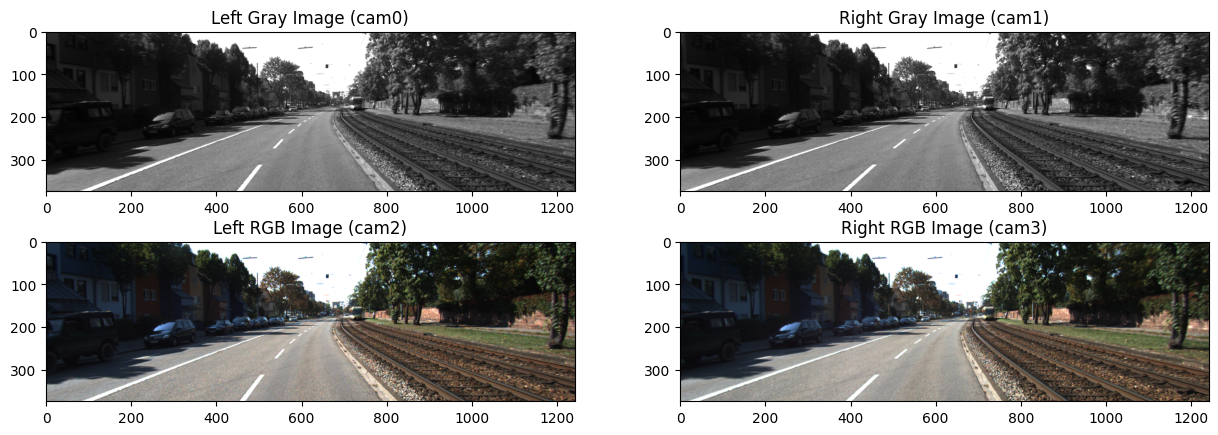

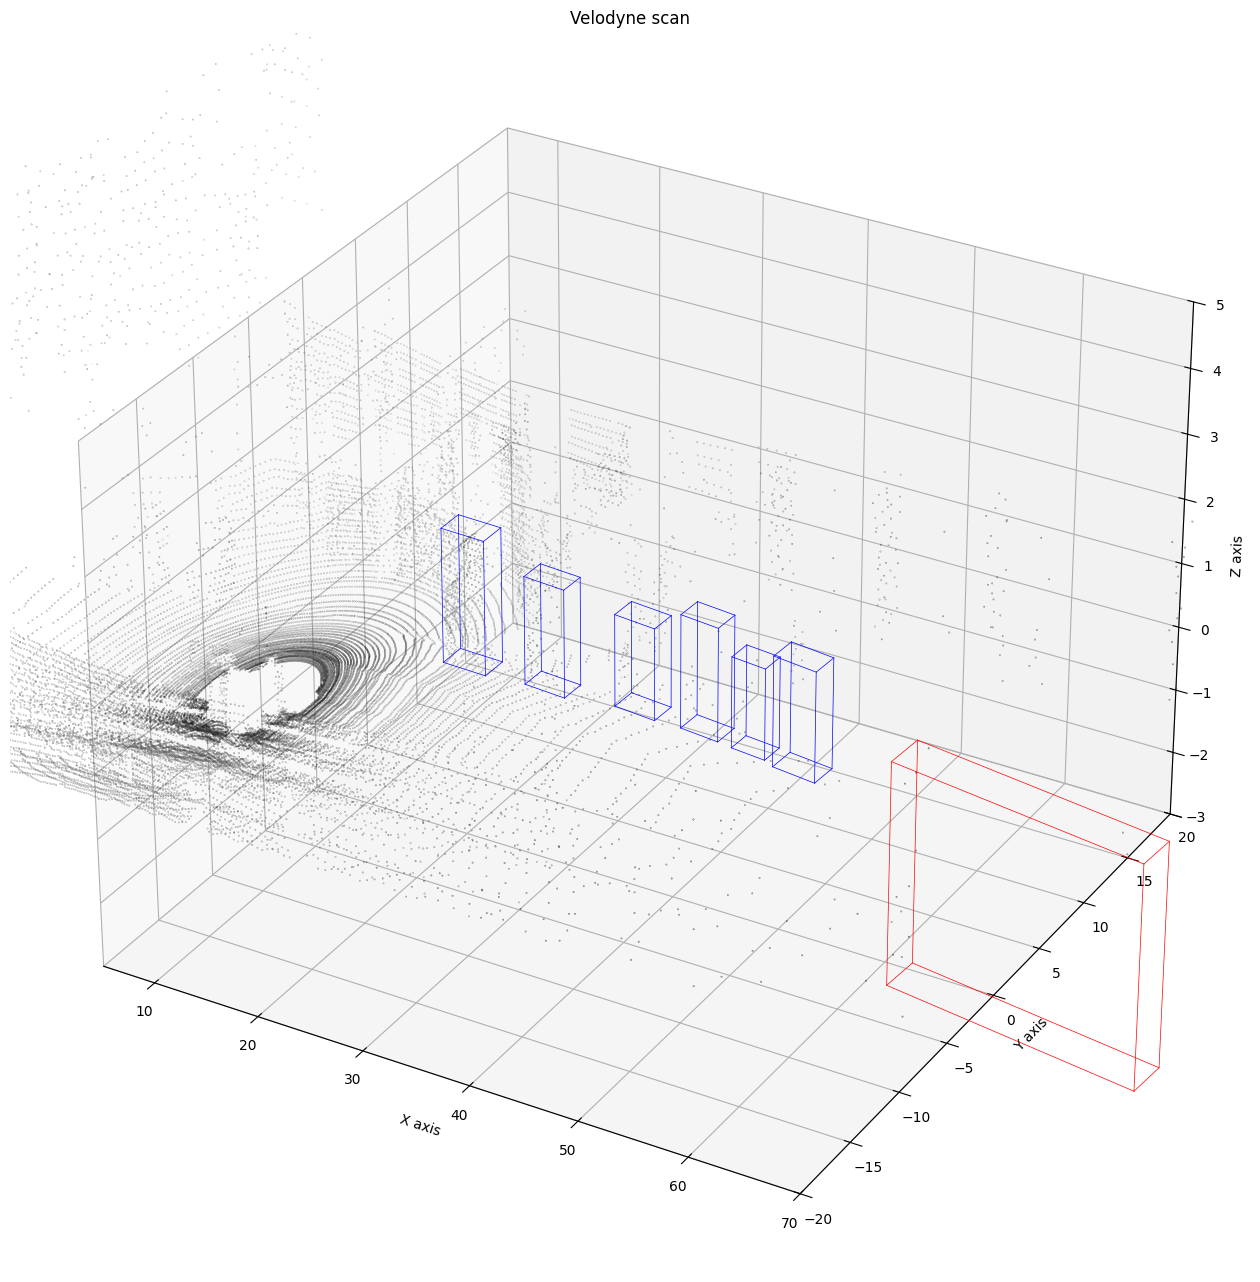

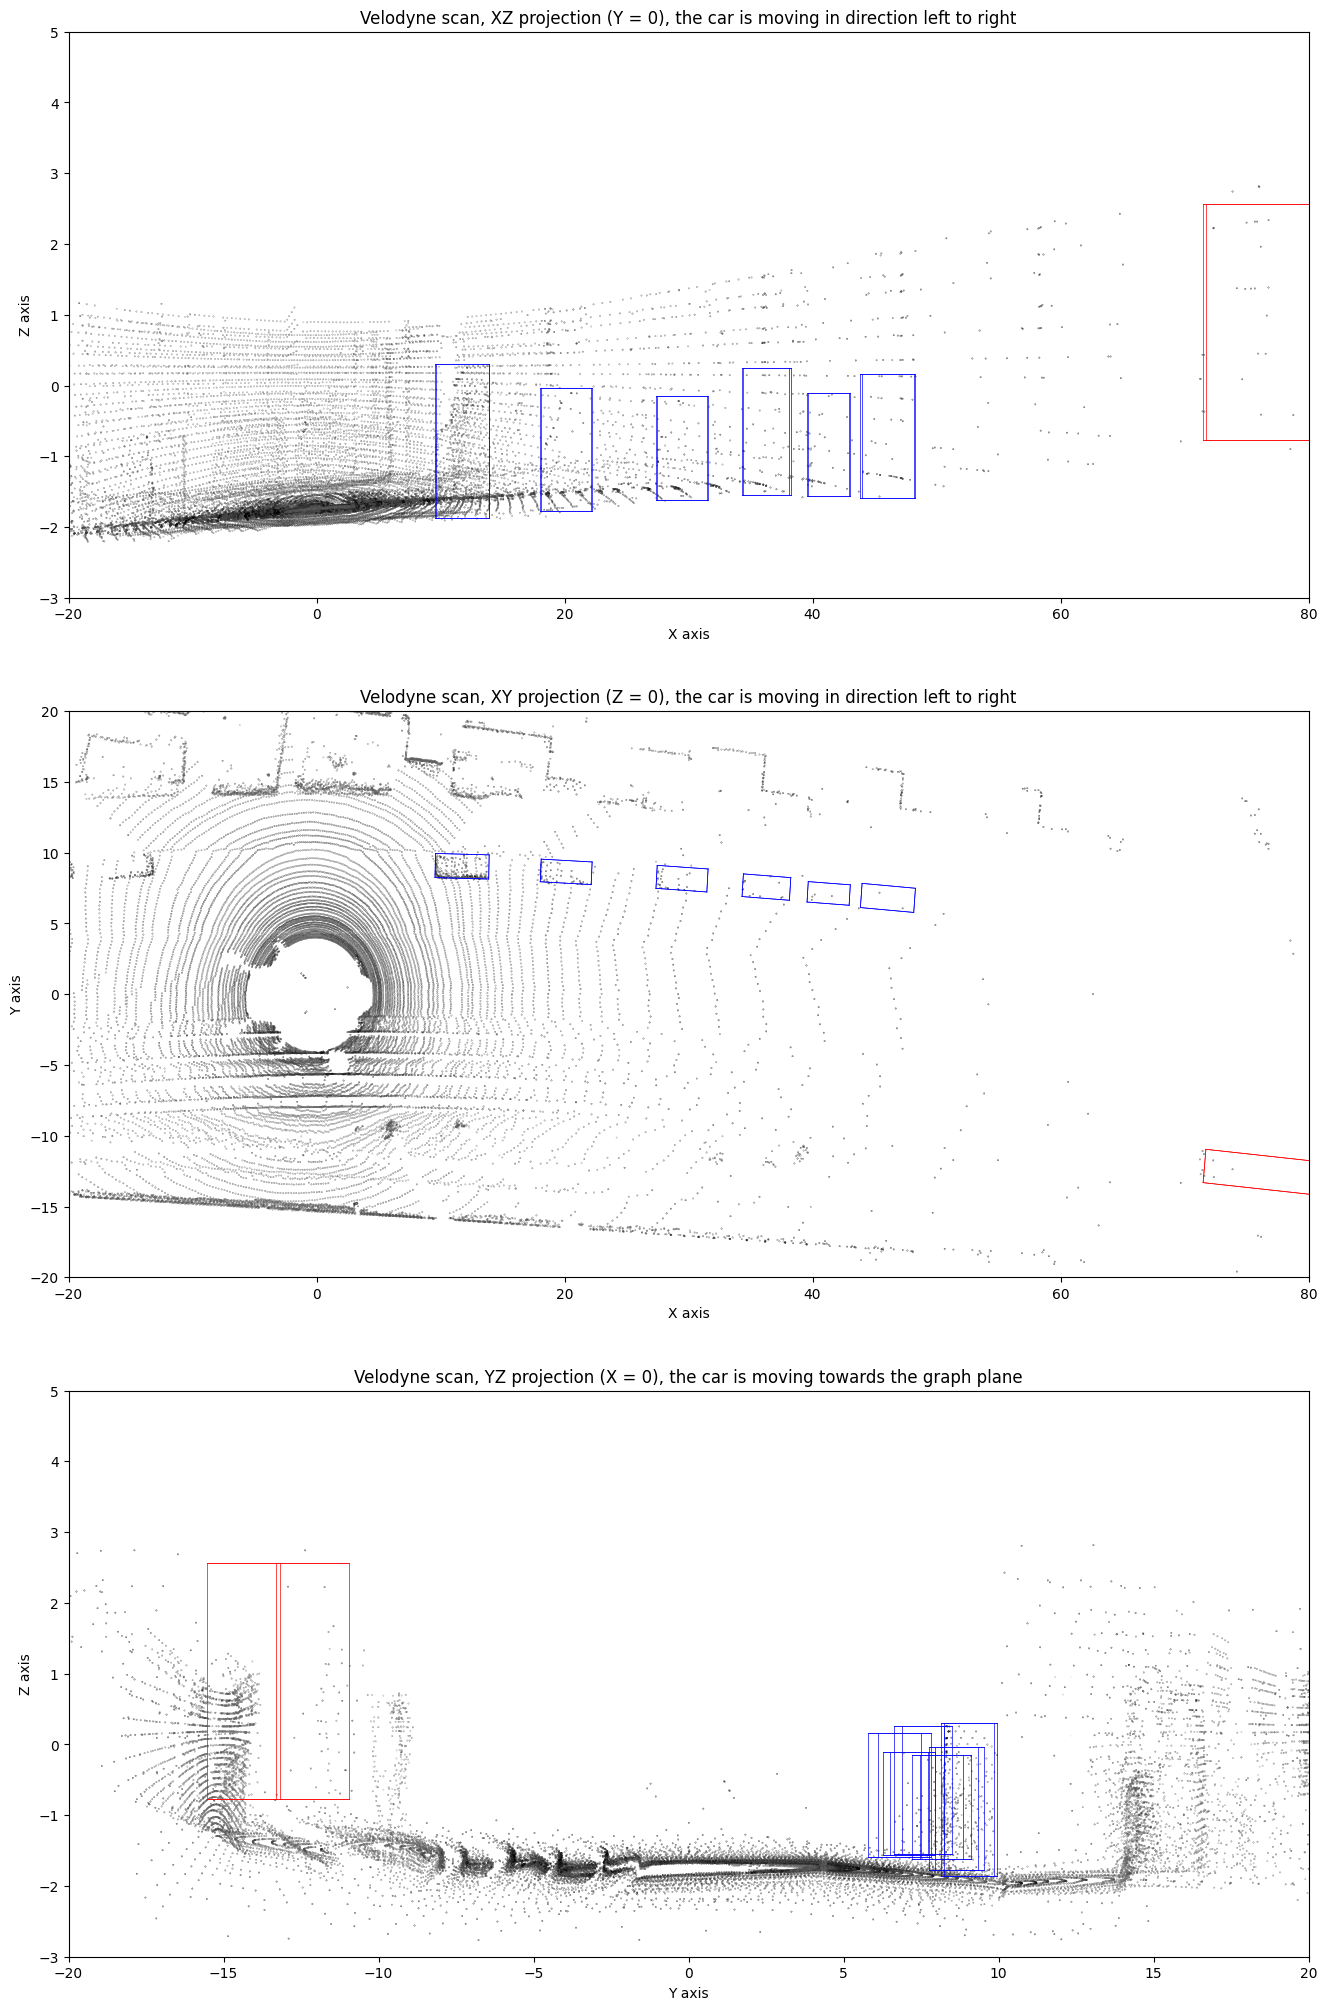

In [ ]:
frame = 10
#-------------------------Вывод всех проекций--------------------------------#
display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame)

In [ ]:
from utilities import print_progress
from moviepy import ImageSequenceClip

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types, points=0.2):
    """
    Saves a single frame for an animation: a 3D plot of the lidar data without ticks and all frame trackelts.
    Parameters
    ----------
    frame           : Absolute number of the frame.
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    Returns
    -------
    Saved frame filename.
    """
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
    filename = 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

#-------------------------Создание кадров--------------------------------#
frames = []
n_frames = len(list(dataset.velo))

print('Preparing animation frames...')
for i in range(n_frames):
    print_progress(i, n_frames - 1)
    filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types)
    frames += [filename]
print('...Animation frames ready.')

#-------------------------Создание анимации--------------------------------#
clip = ImageSequenceClip(frames, fps=5)
#% time
clip.write_gif('pcl_data.gif', fps=5)

Preparing animation frames...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
...Animation frames ready.
MoviePy - Building file pcl_data.gif with imageio.
